# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print('*********************')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
*********************


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [34]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# print(loss)
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.329177
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [44]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.264999 analytic: -0.185317, relative error: 1.000000e+00
numerical: 1.330532 analytic: -1.723067, relative error: 1.000000e+00
numerical: 3.006747 analytic: -0.412728, relative error: 1.000000e+00
numerical: 0.409568 analytic: -2.996029, relative error: 1.000000e+00
numerical: 1.692830 analytic: -1.155999, relative error: 1.000000e+00
numerical: -2.449803 analytic: 1.100654, relative error: 1.000000e+00
numerical: 0.404728 analytic: -0.648627, relative error: 1.000000e+00
numerical: -1.023242 analytic: 0.468930, relative error: 1.000000e+00
numerical: 0.793310 analytic: -1.514088, relative error: 1.000000e+00
numerical: 0.816291 analytic: 0.473981, relative error: 2.653006e-01
numerical: 2.271299 analytic: -2.105917, relative error: 1.000000e+00
numerical: -1.341453 analytic: 0.173064, relative error: 1.000000e+00
numerical: 1.456473 analytic: -2.195696, relative error: 1.000000e+00
numerical: -2.592360 analytic: 2.996688, relative error: 1.000000e+00
numerical: -1.922853 

In [43]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.329177e+00 computed in 0.026045s
vectorized loss: 2.329177e+00 computed in 0.017880s
Loss difference: 0.000000
Gradient difference: 0.000000


In [49]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7,2e-7,3e-7,4e-7,5e-7, 6e-7]
regularization_strengths = [2.5e4,3e4,3.5e4,4e4,4.5e4,5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
ite=2000

for i in learning_rates:
    for j in regularization_strengths:
        soft = Softmax()
        soft.train(X_train,y_train,learning_rate=i,reg=j,num_iters=ite,verbose=True)
        y_predict = soft.predict(X_train)
        train_acc = np.mean(y_predict==y_train)
        y_predict = soft.predict(X_val)
        pred_acc = np.mean(y_predict==y_val)
        results[(i,j)] = (train_acc,pred_acc)
        if pred_acc>best_val:
            best_val=pred_acc
            best_softmax=soft
        

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
# retrain with 2000 iters for better results

iteration 0 / 2000: loss 390.750594
iteration 100 / 2000: loss 237.319916
iteration 200 / 2000: loss 144.541236
iteration 300 / 2000: loss 88.868097
iteration 400 / 2000: loss 54.840935
iteration 500 / 2000: loss 34.535505
iteration 600 / 2000: loss 22.056539
iteration 700 / 2000: loss 14.700415
iteration 800 / 2000: loss 10.121979
iteration 900 / 2000: loss 7.387137
iteration 1000 / 2000: loss 5.793280
iteration 1100 / 2000: loss 4.676866
iteration 1200 / 2000: loss 4.132803
iteration 1300 / 2000: loss 3.810136
iteration 1400 / 2000: loss 3.637812
iteration 1500 / 2000: loss 3.357497
iteration 1600 / 2000: loss 3.367393
iteration 1700 / 2000: loss 3.369642
iteration 1800 / 2000: loss 3.317664
iteration 1900 / 2000: loss 3.352076
iteration 0 / 2000: loss 467.835609
iteration 100 / 2000: loss 256.784386
iteration 200 / 2000: loss 141.631038
iteration 300 / 2000: loss 78.878067
iteration 400 / 2000: loss 44.445938
iteration 500 / 2000: loss 25.833148
iteration 600 / 2000: loss 15.508635


iteration 300 / 2000: loss 4.828434
iteration 400 / 2000: loss 3.185936
iteration 500 / 2000: loss 2.991321
iteration 600 / 2000: loss 3.056051
iteration 700 / 2000: loss 2.958916
iteration 800 / 2000: loss 3.020757
iteration 900 / 2000: loss 2.966650
iteration 1000 / 2000: loss 2.918552
iteration 1100 / 2000: loss 2.922286
iteration 1200 / 2000: loss 2.981565
iteration 1300 / 2000: loss 2.965427
iteration 1400 / 2000: loss 2.989454
iteration 1500 / 2000: loss 2.891069
iteration 1600 / 2000: loss 2.935593
iteration 1700 / 2000: loss 2.855131
iteration 1800 / 2000: loss 3.013072
iteration 1900 / 2000: loss 2.954985
iteration 0 / 2000: loss 383.891189
iteration 100 / 2000: loss 87.013240
iteration 200 / 2000: loss 21.673895
iteration 300 / 2000: loss 7.219775
iteration 400 / 2000: loss 4.063630
iteration 500 / 2000: loss 3.485976
iteration 600 / 2000: loss 3.390437
iteration 700 / 2000: loss 3.272340
iteration 800 / 2000: loss 3.115469
iteration 900 / 2000: loss 3.290142
iteration 1000 /

iteration 800 / 2000: loss 3.044222
iteration 900 / 2000: loss 3.019354
iteration 1000 / 2000: loss 3.033268
iteration 1100 / 2000: loss 2.923905
iteration 1200 / 2000: loss 3.065131
iteration 1300 / 2000: loss 2.945971
iteration 1400 / 2000: loss 3.027102
iteration 1500 / 2000: loss 2.991015
iteration 1600 / 2000: loss 2.994409
iteration 1700 / 2000: loss 3.046390
iteration 1800 / 2000: loss 3.064807
iteration 1900 / 2000: loss 2.978108
iteration 0 / 2000: loss 771.650920
iteration 100 / 2000: loss 16.393903
iteration 200 / 2000: loss 3.152124
iteration 300 / 2000: loss 3.007757
iteration 400 / 2000: loss 2.950861
iteration 500 / 2000: loss 2.980216
iteration 600 / 2000: loss 2.935690
iteration 700 / 2000: loss 3.006990
iteration 800 / 2000: loss 2.865487
iteration 900 / 2000: loss 2.937074
iteration 1000 / 2000: loss 2.991317
iteration 1100 / 2000: loss 2.937663
iteration 1200 / 2000: loss 2.990231
iteration 1300 / 2000: loss 2.950132
iteration 1400 / 2000: loss 2.975408
iteration 15

iteration 1300 / 2000: loss 2.964436
iteration 1400 / 2000: loss 3.003125
iteration 1500 / 2000: loss 3.019926
iteration 1600 / 2000: loss 3.073924
iteration 1700 / 2000: loss 3.059469
iteration 1800 / 2000: loss 2.996241
iteration 1900 / 2000: loss 2.955312
iteration 0 / 2000: loss 695.294459
iteration 100 / 2000: loss 5.863510
iteration 200 / 2000: loss 3.006691
iteration 300 / 2000: loss 3.043212
iteration 400 / 2000: loss 3.125617
iteration 500 / 2000: loss 2.979654
iteration 600 / 2000: loss 3.049808
iteration 700 / 2000: loss 3.095221
iteration 800 / 2000: loss 2.999974
iteration 900 / 2000: loss 2.986535
iteration 1000 / 2000: loss 3.113520
iteration 1100 / 2000: loss 3.022521
iteration 1200 / 2000: loss 2.991722
iteration 1300 / 2000: loss 3.014986
iteration 1400 / 2000: loss 3.010027
iteration 1500 / 2000: loss 3.024212
iteration 1600 / 2000: loss 3.083075
iteration 1700 / 2000: loss 2.968678
iteration 1800 / 2000: loss 3.085858
iteration 1900 / 2000: loss 2.999218
iteration 0

In [50]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.029000


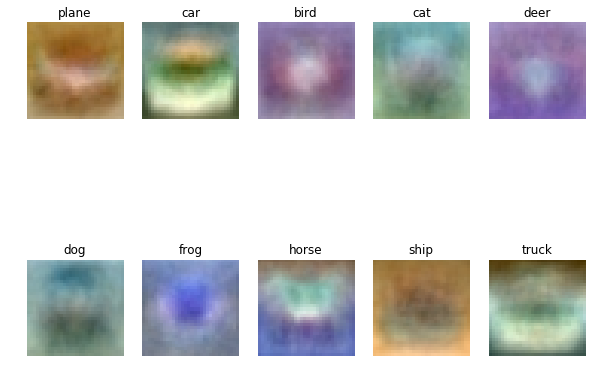

In [51]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])